In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.fft as fft
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import torchvision
import torchvision.transforms as transforms

import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

torch.manual_seed(123)

In [2]:
# dataset loading 
train = pd.read_csv('D:/mnist-digital/mnist_in-csv/mnist_train.csv',dtype=np.float32)
test = pd.read_csv('D:/mnist-digital/mnist_in-csv/mnist_test.csv',dtype=np.float32)


In [3]:
#data processing
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train.loc[:, train.columns != 'label'], 
                                                  train.label, 
                                                  train_size = 0.9, 
                                                  stratify=train.label)
 # loc by key, iloc by index
x_train = x_train.values.reshape(-1,1,28,28) / 255
x_val = x_val.values.reshape(-1,1,28,28) / 255
y_train = y_train.values
y_val = y_val.values
x_test = test.loc[:, test.columns != 'label'].values.reshape(-1,1,28,28) / 255
y_test = test.label.values

In [4]:
#target: label to Detector 
def Detector_Regions(label):
    # sampling number: 256*256
    detector_regions = torch.zeros(84,84) # detector_regions:(84,84) padding:(58,58,58,58)
    Detector_size = 12 # 4.8mm * 4.8mm   12*7=84
    if label < 3:
        d_h = 0
        d_w = label * ( 3 * Detector_size)
    else: 
        if label < 7:
            d_h = 3 * Detector_size
            d_w = (label-3) * (2 * Detector_size)
        else:
            d_h = 6 * Detector_size
            d_w = (label-7) * ( 3 * Detector_size)
    detector_regions[d_h:d_h+Detector_size,d_w:d_w+Detector_size] = 0.5
    pad = nn.ZeroPad2d(padding=(58,58,58,58))
    detector_regions = pad(detector_regions)
    return detector_regions

In [5]:
# Energy Distribution
def count_region(output):
    h = output.shape[-2]
    w = output.shape[-1]
    label_class = 10
    count_region = torch.zeros([output.shape[0],label_class])
    for i in range(label_class):
        detector_region = Detector_Regions(i)
        count_region[:,i] = (output.reshape(-1,h,w) * detector_region).sum(axis = [1,2])
    return count_region
        

In [6]:
# def sampling number
Nx,Ny = [200,200]

In [7]:
to_tensor = transforms.ToTensor()
resize = transforms.Resize([Nx, Ny])

In [8]:
y_train = torch.from_numpy(y_train).type(torch.LongTensor)
y_val = torch.from_numpy(y_val).type(torch.LongTensor)
y_test = torch.from_numpy(y_test).type(torch.LongTensor)

In [9]:
class GetData(Dataset):
    def __init__(self, x_train, y_train, to_tensor, resize):
        self.X = x_train
        self.to_tensor = to_tensor
        self.resize = resize
        self.Y = y_train
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        detector_regions = Detector_Regions(self.Y[index])
        transformed = self.to_tensor(self.X[index]).permute((1, 2, 0)).contiguous()
        transformed = self.resize(transformed)
        #transformed = transformed / torch.sqrt(((transformed)**2).sum() / detector_regions.sum())
        return  transformed,detector_regions.unsqueeze(0)

In [10]:
trainset = GetData(x_train,y_train,to_tensor, resize)
trainloader = DataLoader(trainset, batch_size=8, shuffle=True)

valset = GetData(x_val,y_val,to_tensor, resize)
valloader = DataLoader(valset, batch_size=8, shuffle=True)

In [14]:
# def diffraction function
class Layer(nn.Module):
    def __init__(self,Lx, Ly, Nx, Ny,lam,k,z,):
        super(Layer,self).__init__()
        self.x = np.linspace(-Lx/2,Lx/2,Nx)
        self.x = self.x.astype(np.float32)   # HTRSD: single  ASM: double
        self.y = np.linspace(-Ly/2,Ly/2,Ny)
        self.y = self.y.astype(np.float32)   # HTRSD: single  ASM: double
        self.xx,self.yy = np.meshgrid(self.x, self.y)
        self.dx = Lx / Nx
        self.dy = Ly / Ny
        self.r_max = np.max((self.xx**2 + self.yy**2)**0.5)
        self.z_c = Nx * self.dx**2 / lam
        # Angular specturm
        self.fx = np.linspace(-0.5/self.dx,0.5/self.dx,Nx)
        self.fx = self.fx.astype(np.float32)   # HTRSD: single  ASM: double
        self.fy = np.linspace(-0.5/self.dy,0.5/self.dy,Ny)
        self.fy = self.fy.astype(np.float32)   # HTRSD: single  ASM: double
        self.fxx,self.fyy = np.meshgrid(self.fx, self.fy)
        
        #self.phase = nn.Parameter(torch.rand(Nx, Ny)) 
        self.phase = nn.Parameter(torch.zeros(Nx, Ny))
        
    # CTF
    def H(self,z):
        rho = np.abs(np.sqrt(self.fxx**2 + self.fyy**2))
        temp = lam*rho
        cond = temp < 1 
        CTF = np.where(cond, np.exp(1j*k*z*np.sqrt(np.abs(1-temp**2))), np.exp(-k*z*np.sqrt(np.abs(temp**2-1))))
        return torch.from_numpy(CTF).to(device)
        
    def H_e(self,z,n):
        rho = np.abs(np.sqrt(self.fxx**2 + self.fyy**2))
        temp = lam*rho
        if n == 1:
            CTF = np.exp(1j*k*z)*np.exp(-1j*k*z*0.5*temp**2)
            return torch.from_numpy(CTF).to(device)
        if n == 2:
            CTF = np.exp(1j*k*z)*np.exp(-1j*k*z*0.5*temp**2)*np.exp(-1j*z*k*0.125*temp**4)
            return torch.from_numpy(CTF).to(device)
    # HTRSD
    def forward(self, u1, z, n=1):
        U1 = fft.fft2(fft.fftshift(u1))
        if self.dx <= lam:
            CTF = fft.fftshift(self.H(z))
            return fft.fftshift(fft.ifft2(U1 * CTF))
        if z <= self.z_c:
            CTF = fft.fftshift(self.H_e(z,n))
            return fft.fftshift(fft.ifft2(U1 * CTF))



In [18]:
# def model:  Multilayer  K = 3
class DiffNet(nn.Module):
    def __init__(self):
        super(DiffNet,self).__init__()
        self.input = Layer(Lx,Ly,Nx,Ny,lam,k,d)  # no phase 
        self.difflayer1 = Layer(Lx,Ly,Nx,Ny,lam,k,d)
        self.difflayer2 = Layer(Lx,Ly,Nx,Ny,lam,k,d)
        self.difflayer3 = Layer(Lx,Ly,Nx,Ny,lam,k,d)
        self.difflayer4 = Layer(Lx,Ly,Nx,Ny,lam,k,d)
        self.difflayer5 = Layer(Lx,Ly,Nx,Ny,lam,k,d)
        self.fc1 = nn.Sigmoid()
    def forward(self,u0):
        out = self.input(u0, d)
        out = out * torch.exp(1j*2*torch.pi*self.fc1(self.difflayer1.phase))
        out = self.difflayer1(out, d)
        out = out * torch.exp(1j*2*torch.pi*self.fc1(self.difflayer2.phase))
        out = self.difflayer2(out, d)
        out = out * torch.exp(1j*2*torch.pi*self.fc1(self.difflayer3.phase))
        out = self.difflayer3(out, d)
        out = out * torch.exp(1j*2*torch.pi*self.fc1(self.difflayer4.phase))
        out = self.difflayer4(out, d)
        out = out * torch.exp(1j*2*torch.pi*self.fc1(self.difflayer5.phase))
        out = self.difflayer5(out, d)
        out = torch.abs(out)**2
        out = (out / (out.sum(axis=[-1,-2]).unsqueeze(-1) * torch.ones([1,200,200]).cuda()).unsqueeze(1) * 144*3)
        return out
    
# 此模型的输出是float,注意数据类型匹配 Double but expect Float

# def D2NN parameters
mm = 1e-3
lam = 0.75 * mm
k = 2 * np.pi / lam # wave number
# propagation distance
d = 30 * mm
Lx = 80 * mm
Ly = 80 * mm
dx = Lx / Nx

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = DiffNet().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [20]:
train_acc, train_loss, val_acc, val_loss = [0], [], [0], []

for epoch in range(10):
        
    train_loss_batch, train_acc_batch = 0, 0
    val_loss_batch, val_acc_batch = 0, 0        
    model.train()
    
    for inputs, labels in trainloader:
            
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zero the parameter gradients
        optimizer.zero_grad()
            
        outputs = model(inputs)
            
        loss = loss_fn(outputs, labels)
        
        loss.backward()
        optimizer.step()
            
        train_loss_batch += loss.item()
            
        outputs_region = count_region(outputs.cpu())
        labels_region = count_region(labels.cpu())
            
        _, predicted = torch.max(outputs_region, 1)
        _, y_true = torch.max(labels_region, 1)
            
        correct = (predicted == y_true).sum().item()
            
        train_acc_batch += correct / len(labels)
            
    train_average_accuracy = train_acc_batch / len(trainloader)
    train_average_loss = train_loss_batch / len(trainloader)
    
    train_loss.append(train_average_loss)
    train_acc.append(train_average_accuracy)
    
    model.eval()
    
    with torch.no_grad():
        for inputs, labels in valloader:
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            val_loss_batch += loss.item()
            
            outputs_region = count_region(outputs.cpu())
            labels_region = count_region(labels.cpu())
            
            _, predicted = torch.max(outputs_region, 1)
            _, y_true = torch.max(labels_region, 1)
            
            correct = (predicted == y_true).sum().item()
            val_acc_batch += correct / len(labels)
            
        val_average_accuracy = val_acc_batch / len(valloader)
        val_average_loss = val_loss_batch / len(valloader)
        
        val_loss.append(val_average_loss)
        val_acc.append(val_average_accuracy)
    print('Epoch: %d | Training Loss: %.4f, Validation Loss: %.4f | Train accuracy=:%.5f, Validation accuracy=:%.5f' 
            %(epoch+1, train_average_loss, val_average_loss, train_average_accuracy, val_average_accuracy))

Epoch: 1 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.85294, Validation accuracy=:0.89233
Epoch: 2 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89128, Validation accuracy=:0.89333
Epoch: 3 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89469, Validation accuracy=:0.89967
Epoch: 4 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89833, Validation accuracy=:0.90350
Epoch: 5 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89852, Validation accuracy=:0.89817
Epoch: 6 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89974, Validation accuracy=:0.89967
Epoch: 7 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.89985, Validation accuracy=:0.89667
Epoch: 8 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.90143, Validation accuracy=:0.89950
Epoch: 9 | Training Loss: 0.0004, Validation Loss: 0.0004 | Train accuracy=:0.90111, Val

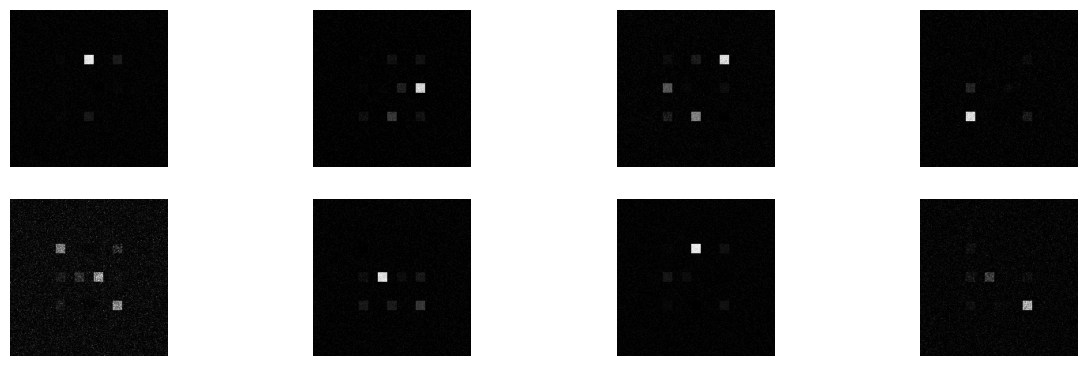

(tensor([1, 6, 2, 7, 5, 4, 1, 9]), tensor([1, 6, 2, 7, 5, 4, 1, 9]))

In [22]:
plt.figure(figsize=(15,4.5))
for i in range(8):  
    plt.subplot(2, 4, i+1)
    plt.imshow(255-outputs[i].cpu().detach().reshape(200,200),cmap=plt.cm.binary)
    plt.axis('off')
plt.show()
predicted,y_true

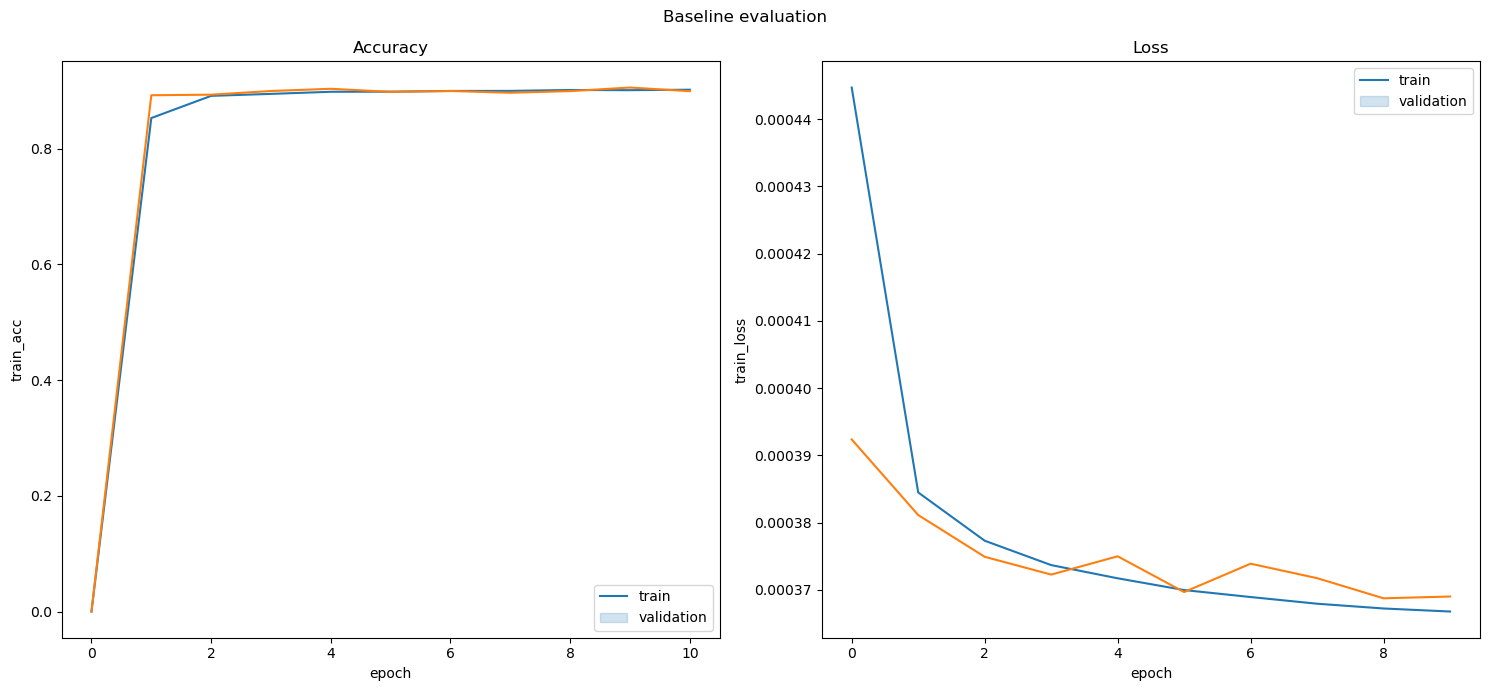

In [23]:
baseline_eval1 = pd.DataFrame({"train_acc": train_acc, "val_acc": val_acc})
baseline_eval2 = pd.DataFrame({"train_loss": train_loss, "val_loss": val_loss})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
fig.suptitle('Baseline evaluation')

sns.lineplot(data=baseline_eval1, x=baseline_eval1.index, y="train_acc", ax=ax1)
sns.lineplot(data=baseline_eval1, x=baseline_eval1.index, y="val_acc", ax=ax1)

sns.lineplot(data=baseline_eval2, x=baseline_eval2.index, y="train_loss", ax=ax2)
sns.lineplot(data=baseline_eval2, x=baseline_eval2.index, y="val_loss", ax=ax2)

ax1.set_title("Accuracy")
ax1.yaxis
ax1.set_xlabel("epoch")
ax1.legend(["train", "validation"])
ax2.set_title("Loss")
ax2.set_xlabel("epoch")
ax2.legend(["train", "validation"])

fig.tight_layout()

In [24]:
# testing
testset = GetData(x_test,y_test,to_tensor, resize)
testloader = DataLoader(testset, batch_size=1, shuffle=True) # batch_size=1

def test(model, testloader, device):
    
    ids = []
    test_pred = []
    test_true = []
    test_acc_batch = 0
    power,SNR = [], []
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs_test = model(inputs)
            
            outputs_region = count_region(outputs_test.cpu())
            labels_region = count_region(labels.cpu())
            

            predicted = torch.argmax(outputs_region, 1)
            y_true = torch.argmax(labels_region, 1)

            #Accuracy
            correct = (predicted == y_true).sum().item()
            test_acc_batch += correct / len(labels)
            
            sorted, indices = torch.sort(outputs_region,dim=-1,descending=True) 
            
            #power efficiency
            if predicted==y_true:
                power_target = sorted[:,0]
                power_sum = outputs_test.sum(axis=[-1,-2])
                power_eff = power_target / sorted.sum()
                power.append(power_eff.item())
            
                #signal contrast
                signal_contrast = (power_target - sorted[:,1]) / power_target
                SNR.append(signal_contrast.item())
            
            ids.append(idx + 1)
            test_pred.append(predicted.item())
            test_true.append(y_true.item())
            
            
        test_average_accuracy = test_acc_batch / len(testloader)
        
    return ids, test_pred,test_true,test_average_accuracy,power,SNR


ids, test_pred,test_true,test_average_accuracy,power,SNR = test(model=model, testloader=testloader, device=device)

In [25]:
def confusion_matrix(preds, labels, conf_matrix):
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

In [26]:
n_class = 10
conf_matrix = torch.zeros(n_class, n_class)
conf_matrix = confusion_matrix(test_pred, test_true, conf_matrix)

In [27]:
conf_matrix = np.array(conf_matrix).astype(np.int16)
corrects=conf_matrix.diagonal(offset=0)
per_kinds=conf_matrix.sum(axis=0)

print(conf_matrix)

# 获取每类数字的识别准确率
print("每类数字总个数：",per_kinds)
print("每类数字预测正确的个数：",corrects)
print("每类数字的识别准确率为：{0}".format([rate*100 for rate in corrects/per_kinds]))


[[ 959    0   16    7    2   12   15    2   19   17]
 [   0 1120    4    3    9    2    3   24   10   10]
 [   0    2  905   22    3    1    2   23   13    3]
 [   0    1   13  871    2   14    0    2   22    9]
 [   0    1   11    3  856    5    4    8   13   31]
 [   3    0    3   56    1  812   20    2   26   11]
 [   9    4   16    6   25   16  911    1   22    4]
 [   1    1   23   17    1    6    1  918   16   11]
 [   8    6   36   14   11   15    2    4  812    4]
 [   0    0    5   11   72    9    0   44   21  909]]
每类数字总个数： [ 980 1135 1032 1010  982  892  958 1028  974 1009]
每类数字预测正确的个数： [ 959 1120  905  871  856  812  911  918  812  909]
每类数字的识别准确率为：[97.85714285714285, 98.6784140969163, 87.6937984496124, 86.23762376237623, 87.16904276985743, 91.03139013452915, 95.09394572025052, 89.29961089494164, 83.3675564681725, 90.08919722497522]


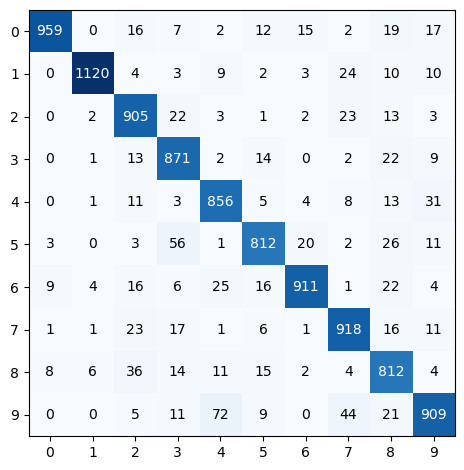

In [28]:
n_class = 10
n_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# 显示数据
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

# 在图中标注数量/概率信息
thresh = conf_matrix.max() / 2 #数值颜色阈值，如果数值超过这个，就颜色加深。
for x in range(n_class):
    for y in range(n_class):

        info = int(conf_matrix[y, x])
        plt.text(x, y, info,
                 verticalalignment='center',
                 horizontalalignment='center',
                 color="white" if info > thresh else "black")
                 
plt.tight_layout()#保证图不重叠
plt.yticks(range(n_class), n_labels)
plt.xticks(range(n_class), n_labels)
plt.show()
plt.close()


In [29]:
test_average_accuracy

0.9073